In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Add,
    Conv2D,
    Input,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    BatchNormalization,
)

In [2]:
num_feature_maps = 32
num_landmarks = 18
num_rb = 1
softargmax_coords = None

In [3]:
def build_rb(x, num_in, num_out):
    half_num_out = max(int(num_out/2), 1)
    
    # Lower branch
    c = x    
    # Conv1
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=half_num_out, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Conv2
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=half_num_out, 
        kernel_size=3, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Conv3
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=num_out, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Upper branch
    s = x
    # Skip
    if num_in == num_out:
        s = tf.identity(s)
    else:
        s = Conv2D(
            filters=num_out, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
           )(s)
    x = Add()([c, s])
    return x

In [6]:
def build_hg(x, steps_to_go, num_features):
    # Upper branch
    up1 = x
    for i in range(num_rb):
        up1 = build_rb(up1, num_features, num_features)
    
    # Lower branch
    low1 = keras.layers.MaxPool2D(pool_size=2)(x)
    for i in range(num_rb):
        low1 = build_rb(low1, num_features, num_features)
        
    # Recursive
    if steps_to_go > 1:
        low2 = build_hg(low1, steps_to_go=steps_to_go-1, num_features=num_features)
    else:
        low2 = low1
        for i in range(num_rb):
            low2 = build_rb(low2, num_features, num_features)
            
    # Additional rb
    low3 = low2
    for i in range(num_rb):
        low3 = build_rb(low3, num_features, num_features)
        
    # Upsampling
    up2 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(low3)
    
    x = keras.layers.Add()([up1, up2])
    return x

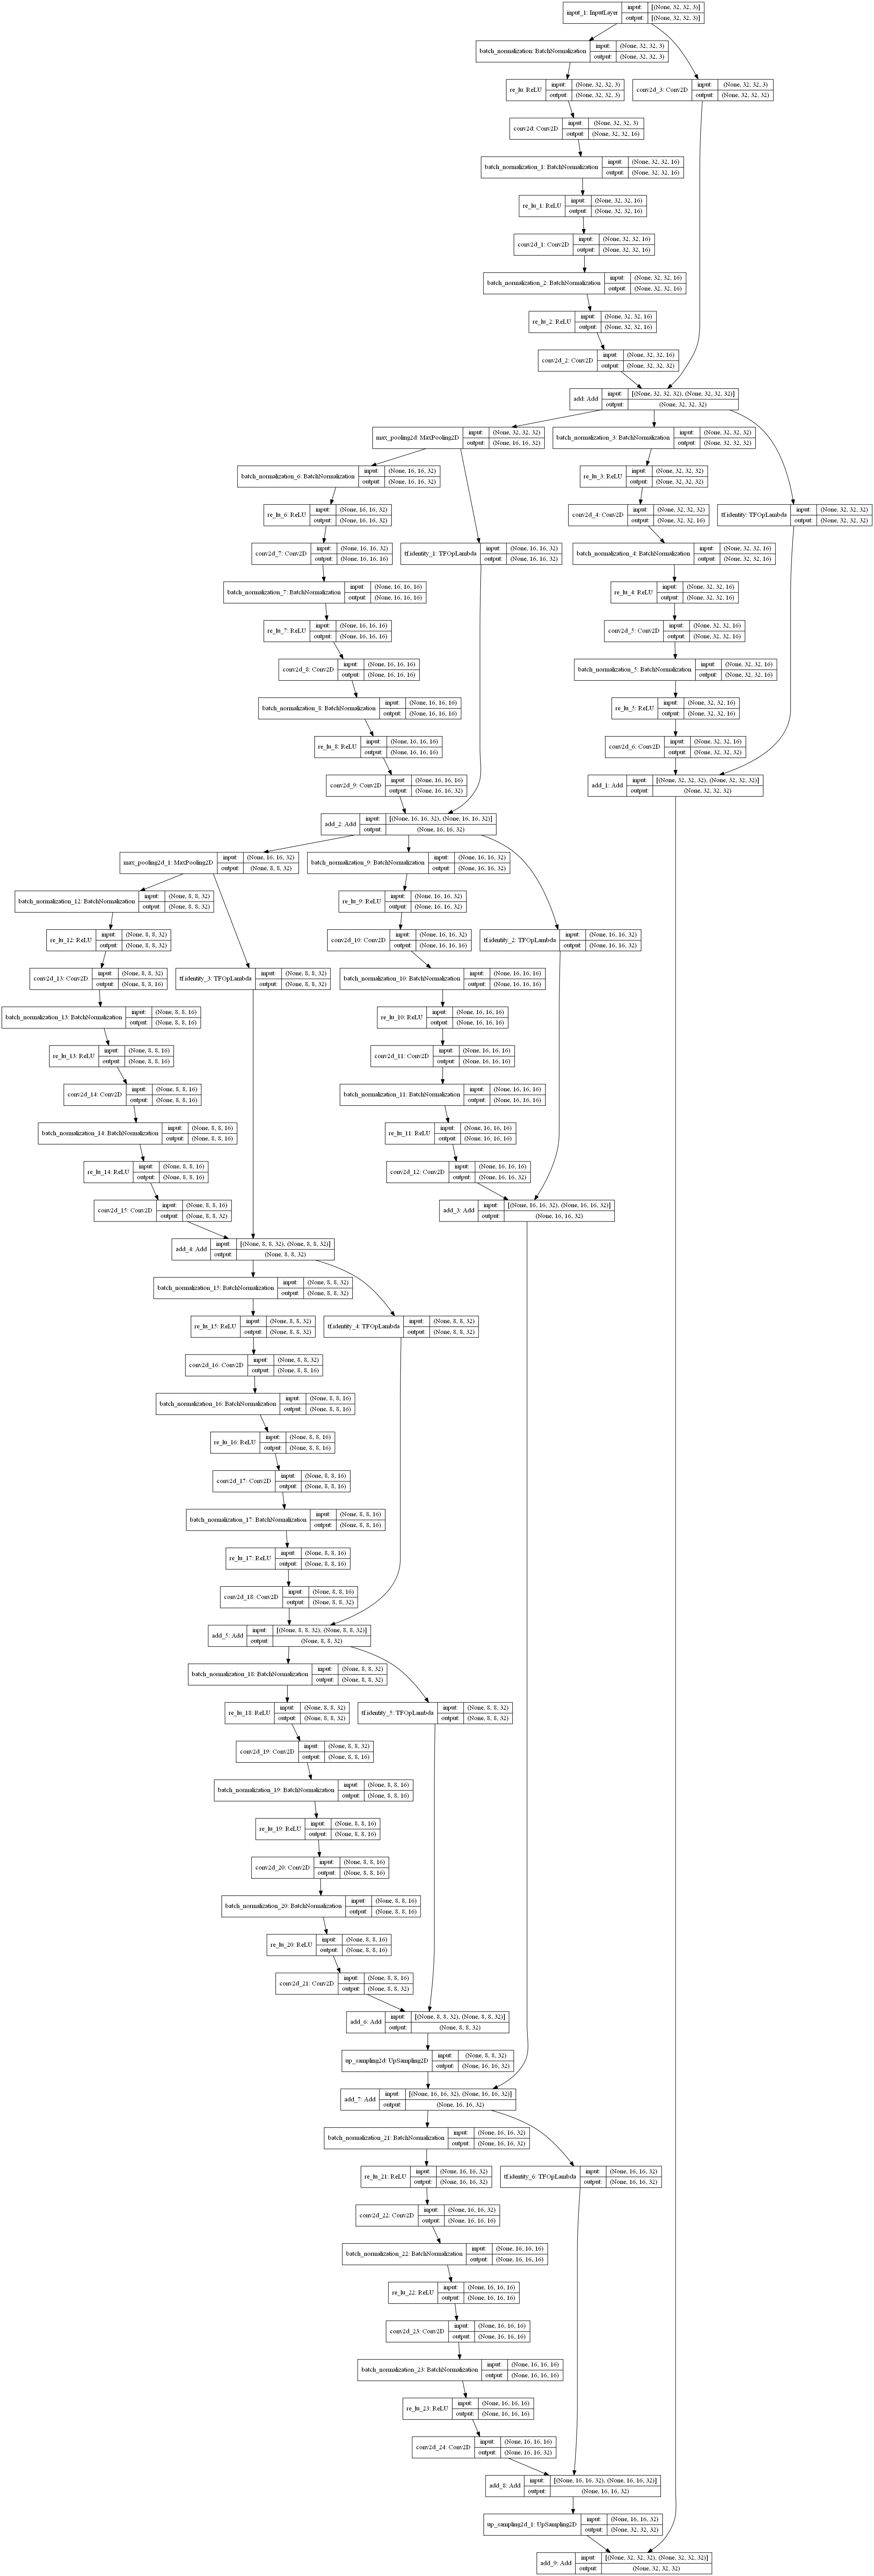

In [7]:
inputs = keras.Input(shape=(32, 32, 3))
x = build_rb(inputs, 3, 32)
x = build_hg(x, 2, 32)

model = keras.Model(inputs, x)
keras.utils.plot_model(model, "hg_test.png", show_shapes=True)

In [4]:
def build_hg_after(x_prev, x_now, do_merge=True):
    # After
    for i in range(num_rb):
        x_now = build_rb(x_now, num_feature_maps, num_feature_maps)
    
    # A linear layer to predict each channel like a fc layer
    # Create the last feature_maps for heatmaps' creation
    x_now = keras.layers.Conv2D(
        filters=num_feature_maps, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
        )(x_now)
    x_now = keras.layers.BatchNormalization(scale=True, center=True, trainable=True)(x_now)
    x_now = keras.layers.ReLU()(x_now)
    
    # Heatmaps, the num of heatmaps is also num of landmarks
    h = keras.layers.Conv2D(
        filters=num_landmarks, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
        )(x_now)
    
    # Save feature_maps for next stack of hg
    x_next = x_now
    
    # Merge heatmaps and feature_maps
    # First, do conv for heatmaps and feature_maps, then merge them
    if do_merge:
        h_merge_1 = keras.layers.Conv2D(
            filters=num_feature_maps, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
            )(h)
        h_merge_2 = keras.layers.Conv2D(
            filters=num_feature_maps, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
            )(x_now)
        
        # Save the information of feature_maps and merged heat_maps
        h_merged = keras.layers.Add()([h_merge_1, h_merge_2])
        x_next = keras.layers.Add()([x_next, h_merged])
    return x_next, h

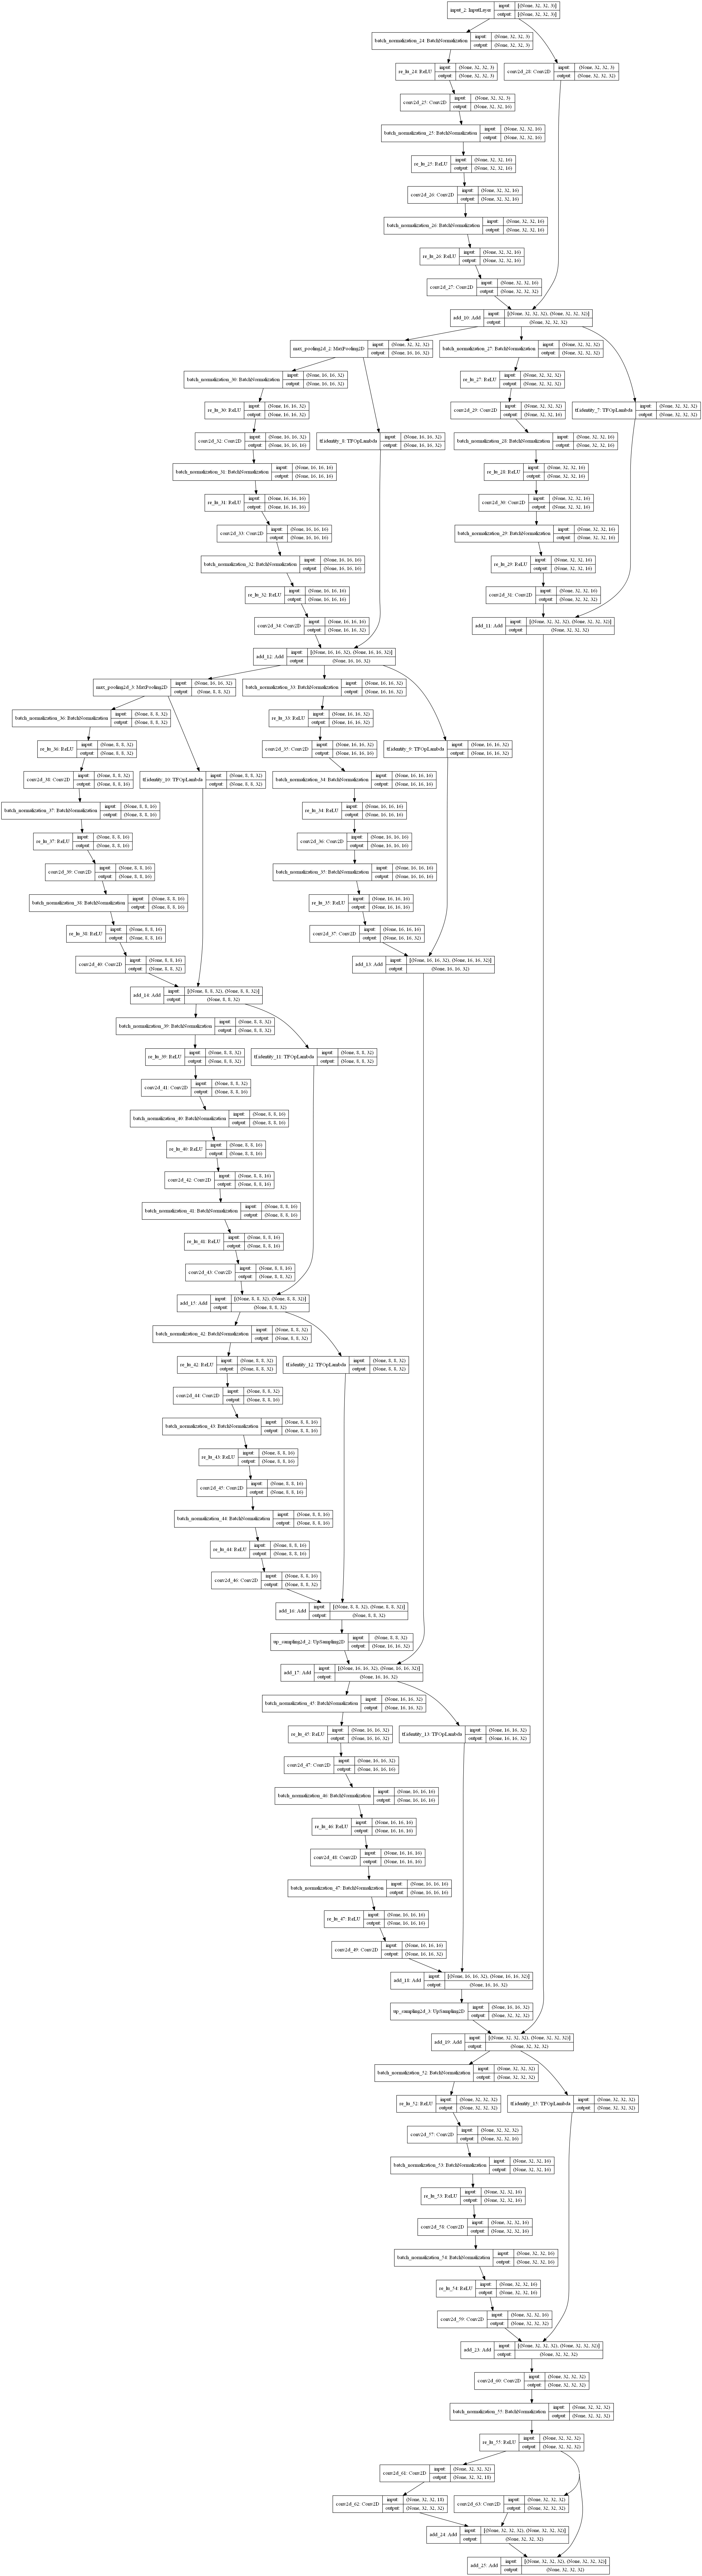

In [9]:
inputs = keras.Input(shape=(32, 32, 3))
x = build_rb(inputs, 3, num_feature_maps)
x = build_hg(x, 2, num_feature_maps)
x1, h1 = build_hg_after(tf.zeros(shape=(32, 32, num_feature_maps)), x)
x2, h2 = build_hg_after(x1, x)

model = keras.Model(inputs, x2)
keras.utils.plot_model(model, "hg_after_test.png", show_shapes=True)

In [5]:
# After cal_landmarks() we can get positions of different landmarks(in different channels)
# Each channel has one pair of coordinates
def cal_landmarks(x):
    _, h, w, _ = x.shape.as_list()
    
    if softargmax_coords is None:
        # Assume normalized coordinate [0, 1] for numeric stability
        ref_xs, ref_ys = np.meshgrid(
            np.linspace(0, 1.0, num=w, endpoint=True),
            np.linspace(0, 1.0, num=h, endpoint=True),
            indexing='xy'
        )
        
        # Why is shape [-1, h*w]?
        ref_xs = np.reshape(ref_xs, [-1, h*w])
        ref_ys = np.reshape(ref_ys, [-1, h*w])
        # Create tuple for softargmax_coords
        softargmax_coords = (
            tf.constant(ref_xs, dtype=tf.float32),
            tf.constant(ref_ys, dtype=tf.float32)
        )
    
    ref_xs, ref_ys = softargmax_coords
    
    # Assuming N x 45 x 75 x 18 (NHWC)
    beta = 1e2
    # Transpose x from NHWC to NCHW
    x = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(x, [-1, num_landmarks, h*w])
    x = keras.layers.Softmax(axis=-1)(beta*x)
    lmrk_xs = tf.math.reduce_sum(ref_xs * x, axis=[2])
    lmrk_ys = tf.math.reduce_sum(ref_ys * x, axis=[2])
    
    # Return to actual coordinates ranges
    return tf.stack([
        lmrk_xs * (w - 1.0) + 0.5,
        lmrk_ys * (h - 1.0) + 0.5
    ], axis=2) # N x 18 x 2

In [11]:
# Example for cal_landmarks() method

h = 2
w = 3
ref_xs, ref_ys = np.meshgrid(
    np.linspace(0, 1.0, num=w, endpoint=True),
    np.linspace(0, 1.0, num=h, endpoint=True),
    indexing='xy'
)
print(ref_xs)
print(ref_ys)
print('\n')
ref_xs = np.reshape(ref_xs, [-1, h*w])
ref_ys = np.reshape(ref_ys, [-1, h*w])
print(ref_xs)
print(ref_ys)
print('\n')
softargmax_coords = (
    tf.constant(ref_xs, dtype=tf.float32),
    tf.constant(ref_ys, dtype=tf.float32)
)
print(softargmax_coords)
print('\n')
# ref_xs and ref_ys are Meshmasks for Heatmaps
ref_xs, ref_ys = softargmax_coords
print(ref_xs)
print(ref_ys)
print('\n')
# Assuming 1 x 2 x 3 x 3 (NHWC) 3 Channels map to 3 Landmarks
x = tf.constant([[[[1, 1, 1], [2, 2, 2], [3, 3, 3]],
                  [[4, 4, 4], [5, 5, 5], [6, 6, 6]]]], dtype=tf.float32)
print(x)
print('\n')
beta = 1
# Transpose x from NHWC to NCHW,
# by NCHW we can simply reshape Heatmaps to match ref_xs and ref_ys size
x = tf.transpose(x, (0, 3, 1, 2))
print(x)
print('\n')
x = tf.reshape(x, [-1, 3, h*w])
print(x)
print('\n')
x = keras.layers.Softmax(axis=-1)(beta*x)
print(x)
print('\n')
lmrk_xs = tf.math.reduce_sum(ref_xs * x, axis=[2])
lmrk_ys = tf.math.reduce_sum(ref_ys * x, axis=[2])
print(lmrk_xs)
print(lmrk_ys)
print('\n')
# The output is the pixels(positions) for different channels(landmarks) 
tf.stack([
    lmrk_xs * (w - 1.0) + 0.5,
    lmrk_ys * (h - 1.0) + 0.5
], axis=2) 

[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]


[[0.  0.5 1.  0.  0.5 1. ]]
[[0. 0. 0. 1. 1. 1.]]


(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0. , 0.5, 1. , 0. , 0.5, 1. ]], dtype=float32)>, <tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 0., 0., 1., 1., 1.]], dtype=float32)>)


tf.Tensor([[0.  0.5 1.  0.  0.5 1. ]], shape=(1, 6), dtype=float32)
tf.Tensor([[0. 0. 0. 1. 1. 1.]], shape=(1, 6), dtype=float32)


tf.Tensor(
[[[[1. 1. 1.]
   [2. 2. 2.]
   [3. 3. 3.]]

  [[4. 4. 4.]
   [5. 5. 5.]
   [6. 6. 6.]]]], shape=(1, 2, 3, 3), dtype=float32)


tf.Tensor(
[[[[1. 2. 3.]
   [4. 5. 6.]]

  [[1. 2. 3.]
   [4. 5. 6.]]

  [[1. 2. 3.]
   [4. 5. 6.]]]], shape=(1, 3, 2, 3), dtype=float32)


tf.Tensor(
[[[1. 2. 3. 4. 5. 6.]
  [1. 2. 3. 4. 5. 6.]
  [1. 2. 3. 4. 5. 6.]]], shape=(1, 3, 6), dtype=float32)


tf.Tensor(
[[[0.00426978 0.01160646 0.03154963 0.08576079 0.23312204 0.6336913 ]
  [0.00426978 0.01160646 0.03154963 0.08576079 0.23312204 0.6336913 ]
  [0.00426

<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[2.0752103, 1.4525741],
        [2.0752103, 1.4525741],
        [2.0752103, 1.4525741]]], dtype=float32)>